In [1]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset_new_v2 import Dataset, load_dataframes_from_folder, reverse_normalization, normalize_fixed_ranges
from torch.utils.data import DataLoader
from transformer_zerostep_new_v2 import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt
import glob
import pandas as pd

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [3]:
# Overall settings
out_dir = "out"
batch_size = 1024

model_name = "ckpt_50pct_recursive_h10_real_val_speed_correction_low_speed_v2.pt"
# folder_path = '../data/CL_experiments_double_sensor_low_speed/train/inertia13_ki-0.0029-kp-3.0000'
folder_path = '../data/CL_experiments_double_sensor_low_speed_ekf/'
save_folder_path = '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/'
# folder_path = '../../../in-context-bldc-data/simulated/50_percent_with_alfa_beta_speed_corrected'

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
print(torch.cuda.is_available())
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/model_name, map_location=device, weights_only=False)
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx
exp_data["iter_num"]
print(seq_len)
print(exp_data["iter_num"])
print(exp_data['best_val_loss'])
print(exp_data["cfg"])
print(exp_data["cfg"].lr)

True
10
4931
0.00044166864245198667
Namespace(model_dir='out', out_file='ckpt_50pct_recursive_h10_real_val_speed_correction_low_speed_v2', in_file='ckpt_50pct_recursive_h10_real_val_speed_correction_low_speed_v2', init_from='scratch', seed=42, log_wandb=False, nx=4, nu=5, ny=1, seq_len=10, mag_range=(0.5, 0.97), phase_range=(0.0, 1.5707963267948966), fixed_system=False, n_layer=8, n_head=4, n_embd=16, dropout=0, bias=False, batch_size=128, max_iters=8000, warmup_iters=5000, lr=1e-05, weight_decay=0.0, eval_interval=10, eval_iters=10, fixed_lr=False, threads=16, no_cuda=False, cuda_device='cuda:0', compile=False, beta1=0.9, beta2=0.95, block_size=10, lr_decay_iters=8000, min_lr=1.0000000000000002e-06, decay_lr=True, eval_batch_size=128)
1e-05


In [4]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    if k.startswith('module.'):
        state_dict[k[7:]] = v
        state_dict.pop(k)

model.load_state_dict(state_dict)

number of parameters: 0.03M


<All keys matched successfully>

In [15]:
final_folder = folder_path + "final/"
final_fixed_folder = folder_path + "final_fixed/"

save_final_folder = save_folder_path + "final/"
save_final_fixed_folder = save_folder_path + "final_fixed/"

final_folder_list = glob.glob(os.path.join(final_folder, "*"))
# print(final_folder_list)
for i in range(len(final_folder_list)):
    # print(final_folder_list[i])
    foldername = str(final_folder_list[i]).split("\\")[-1]
    # print(foldername)
    csv_list = glob.glob(os.path.join(final_folder_list[i], "*.csv"))
    try:
        os.mkdir(os.path.join(save_final_folder, foldername))
    except OSError as error:
        print(error)    
    for file in csv_list:

        filename = str(file).split("\\")[-1]
        # print(filename)

        df = pd.read_csv(file)
        omega = df['omega'].to_numpy()
        last_idx = np.argwhere(omega>0)[-1] +1
        first_idx = last_idx - 2200 -1
        # print(first_idx)
        # print(len(df))

        df.drop(df.tail(len(df)-last_idx[0]).index, inplace=True) # drop last n rows
        df.drop(df.head(first_idx[0]).index, inplace=True) # drop first n rows
        omega = df['omega'].to_numpy()
        df["t"] = df["t"].to_numpy() - df["t"].to_numpy()[0]
        # plt.figure()
        # plt.plot(omega)

        df.to_csv(os.path.join(save_final_folder, foldername, filename))


[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final/inertia05_ki-0.0029-kp-3.0000'
[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final/inertia07_ki-0.0029-kp-3.0000'
[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final/inertia09_ki-0.0029-kp-3.0000'
[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final/inertia11_ki-0.0029-kp-3.0000'
[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final/inertia13_ki-0.0029-kp-3.0000'
[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final/inertia15_ki-0.0029-kp-3.0000'


[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final_fixed/inertia05_ki-0.0029-kp-3.0000'
0.0
[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final_fixed/inertia07_ki-0.0029-kp-3.0000'
0.0
[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final_fixed/inertia09_ki-0.0029-kp-3.0000'
0.0
[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final_fixed/inertia11_ki-0.0029-kp-3.0000'
0.0
[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final_fixed/inertia13_ki-0.0029-kp-3.0000'
0.0
[WinError 183] Impossibile creare un file, se il file esiste già: '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/fin

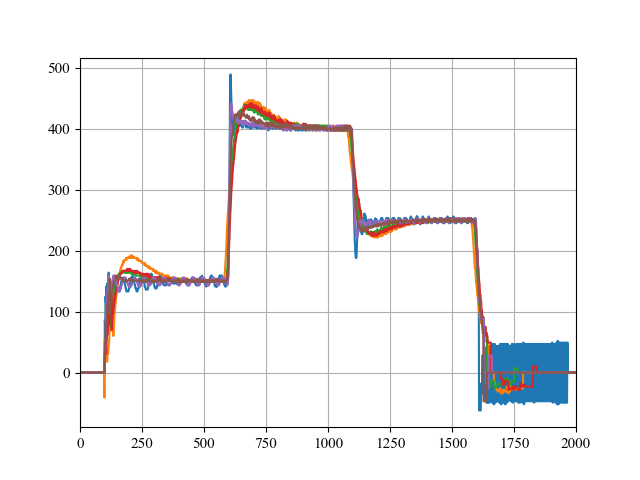

In [14]:

plt.figure()

final_fixed_folder_list = glob.glob(os.path.join(final_fixed_folder, "*"))
for i in range(len(final_fixed_folder_list)):
    foldername = str(final_fixed_folder_list[i]).split("\\")[-1]
    # print(foldername)
    csv_list = glob.glob(os.path.join(final_fixed_folder_list[i], "*.csv"))
    try:
        os.mkdir(os.path.join(save_final_fixed_folder, foldername))
    except OSError as error:
        print(error)    
    for file in csv_list:

        filename = str(file).split("\\")[-1]
        # print(filename)

        df = pd.read_csv(file)
        omega = df['omega'].to_numpy()

        first_idx = np.argwhere(omega>0)[0] -100

        last_idx = first_idx + 2001
        # print(first_idx)
        # print(len(df))

        df.drop(df.tail(len(df)-last_idx[0]).index, inplace=True) # drop last n rows
        df.drop(df.head(first_idx[0]).index, inplace=True) # drop first n rows
        omega = df['omega'].to_numpy()
        # plt.figure()
        plt.plot(omega)

        df["t"] = df["t"].to_numpy() - df["t"].to_numpy()[0]
        print(df["t"].to_numpy()[0])

        df.to_csv(os.path.join(save_final_fixed_folder, foldername, filename))




        # print(len(omega))

plt.show()